In [1]:
!pip install torch torchvision transformers pillow numpy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Loading CLIP model and processor...
CLIP model loaded successfully!
Loading images from 'images'...
Loaded: 310715139_7f05468042.jpg
Loaded: 311619377_2ba3b36675.jpg
Loaded: 322050103_145f7233c6.jpg
Loaded: 324355356_859988a710.jpg
Loaded: 341665272_80d4d61376.jpg
Loaded: 315125146_d9a8e60061.jpg
Loaded: 336551609_1385ab139e.jpg
Loaded: 326456451_effadbbe49.jpg
Loaded: 33108590_d685bfe51c.jpg
Loaded: 3101796900_59c15e0edc.jpg
Loaded: 319869052_08b000e4af.jpg
Loaded: 317109978_cb557802e1.jpg
Loaded: 328916930_e4d4be1730.jpg
Loaded: 339658315_fbb178c252.jpg
Loaded: 3098824948_23c31df031.jpg
Loaded: 333973142_abcd151002.jpg
Loaded: 318667317_108c402140.jpg
Loaded: 314603661_51e05e0e24.jpg
Extracting image features (embeddings)... This might take a moment.
Image features extracted.

Enter your search query (e.g., 'a cat in a garden', 'a fast car', or 'exit' to quit): image with black dog

Searching for: 'image with black dog'...

Top 3 results for 'image with black dog':
- images/333973142

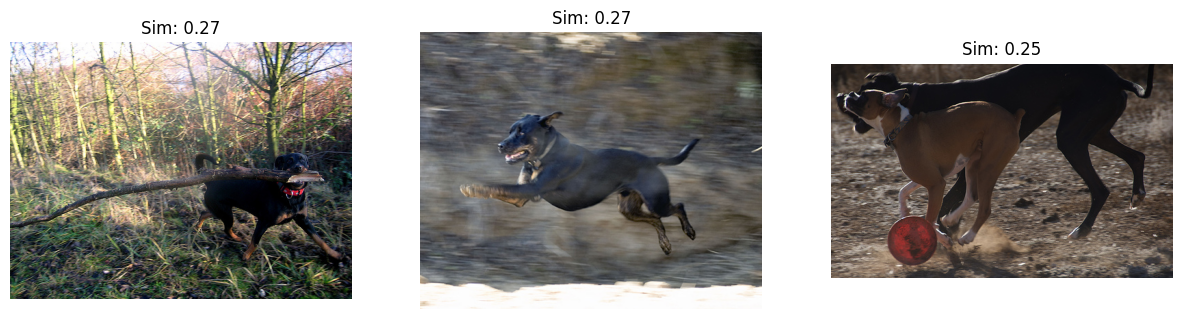

In [ ]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import os
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt


print("Loading CLIP model and processor...")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
print("CLIP model loaded successfully!")


image_folder = "images"


image_paths = []
images = []

print(f"Loading images from '{image_folder}'...")
if not os.path.exists(image_folder):
    print(f"Error: Image folder '{image_folder}' not found. Please create it and upload images.")
else:
    for filename in os.listdir(image_folder):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".gif", ".bmp")):
            path = os.path.join(image_folder, filename)
            try:
                img = Image.open(path).convert("RGB")
                images.append(img)
                image_paths.append(path)
                print(f"Loaded: {filename}")
            except Exception as e:
                print(f"Error loading {filename}: {e}")

if not images:
    print(f"No valid images found in '{image_folder}'. Please add some images or check the folder path.")
else:

    print("Extracting image features (embeddings)... This might take a moment.")
    with torch.no_grad():
        inputs = processor(images=images, return_tensors="pt", padding=True)
        image_features = model.get_image_features(**inputs).to("cuda" if torch.cuda.is_available() else "cpu")
        image_features_norm = image_features / image_features.norm(dim=-1, keepdim=True)
    print("Image features extracted.")

    # --- 4. تابع جستجو ---
    def search_images(query_text, top_k=3):
        print(f"\nSearching for: '{query_text}'...")

        with torch.no_grad():
            inputs = processor(text=[query_text], return_tensors="pt", padding=True)
            text_features = model.get_text_features(**inputs).to("cuda" if torch.cuda.is_available() else "cpu")
            text_features_norm = text_features / text_features.norm(dim=-1, keepdim=True)

        similarities = cosine_similarity(text_features_norm.cpu().numpy(), image_features_norm.cpu().numpy())[0]
        top_indices = np.argsort(similarities)[::-1][:top_k]

        print(f"\nTop {top_k} results for '{query_text}':")


        plt.figure(figsize=(15, 5))
        for i, idx in enumerate(top_indices):
            img_path = image_paths[idx]
            similarity_score = similarities[idx]

            print(f"- {img_path} (Similarity: {similarity_score:.4f})")


            try:
                img = Image.open(img_path).convert("RGB")
                plt.subplot(1, top_k, i + 1)
                plt.imshow(img)
                plt.title(f"Sim: {similarity_score:.2f}")
                plt.axis('off')
            except Exception as e:
                print(f"Could not display image {img_path}: {e}")

        plt.show()

        return [image_paths[i] for i in top_indices]


    if __name__ == "__main__":
        while True:
            user_query = input("\nEnter your search query (e.g., 'a cat in a garden', 'a fast car', or 'exit' to quit): ")
            if user_query.lower() == 'exit':
                print("Exiting search. Goodbye!")
                break

            search_images(user_query, top_k=3)